In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
cnxn = create_engine('sqlite:///vn.db')

In [27]:
query = "SELECT * FROM HSX WHERE ticker = 'VNM' ORDER BY date"

In [28]:
df = pd.read_sql(query, cnxn, parse_dates=['date'])

In [29]:
df.describe()

,open,high,low,close,volume
count,1786.000000,1786.000000,1786.000000,1786.000000,1.786000e+03
mean,133.817187,135.064601,132.614438,133.833748,6.795340e+05
std,24.408896,24.654265,24.183623,24.414425,6.396641e+05
min,83.700000,88.300000,83.700000,83.700000,1.413000e+03
25%,117.550000,118.725000,116.225000,117.600000,2.326225e+05
50%,133.000000,134.000000,131.850000,133.000000,5.419450e+05
75%,143.000000,144.375000,142.000000,143.000000,9.106450e+05
max,214.000000,215.000000,213.100000,214.800000,9.270450e+06


In [30]:
df['mid'] = (df['high'] + df['low']) / 2

In [31]:
train_set = df[['mid']].iloc[:-40,:]
test_set = df[['mid']].iloc[-40:,:]

In [32]:
day_to_window = 30

In [33]:
sc = MinMaxScaler(feature_range=(0,1))
stage_train = sc.fit_transform(train_set.values.reshape(-1,1))
X_train = []
y_train = []
for i in range(day_to_window, len(stage_train)):
    X_train.append(stage_train[i-day_to_window:i, :])
    y_train.append(stage_train[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [34]:
dataset_total = pd.concat((train_set, test_set), axis = 0)
inputs = dataset_total[len(df) - len(test_set) - day_to_window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(day_to_window, day_to_window + len(test_set)):
    X_test.append(inputs[i-day_to_window:i, :])
    y_test.append(inputs[i, :])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1, activation='relu'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

nn = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size = 32)

_loss: 1.8660e-04 - val_mean_absolute_error: 0.0093
Epoch 87/200
54/54 [==============================] - 2s 31ms/step - loss: 9.0796e-04 - mean_absolute_error: 0.0208 - val_loss: 3.0888e-04 - val_mean_absolute_error: 0.0147
Epoch 88/200
54/54 [==============================] - 2s 32ms/step - loss: 8.8931e-04 - mean_absolute_error: 0.0207 - val_loss: 1.8847e-04 - val_mean_absolute_error: 0.0098
Epoch 89/200
54/54 [==============================] - 2s 31ms/step - loss: 8.6958e-04 - mean_absolute_error: 0.0199 - val_loss: 2.8053e-04 - val_mean_absolute_error: 0.0116
Epoch 90/200
54/54 [==============================] - 2s 31ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 2.4025e-04 - val_mean_absolute_error: 0.0119
Epoch 91/200
54/54 [==============================] - 2s 31ms/step - loss: 9.4374e-04 - mean_absolute_error: 0.0209 - val_loss: 1.6754e-04 - val_mean_absolute_error: 0.0086
Epoch 92/200
54/54 [==============================] - 2s 32ms/step - loss: 7.7909e-04 -

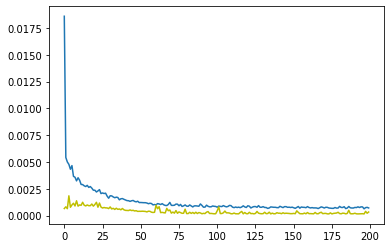

In [36]:
fig, ax = plt.subplots()
ax.plot(nn.history['loss'])
ax.plot(nn.history['val_loss'], color='y')

In [37]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [38]:
real = test_set.values

In [39]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='real',
        x=df.iloc[-40:,:]['date'],
        y=real.flatten()
    )
)

fig.add_trace(
    go.Scatter(
        name='pred',
        x=df.iloc[-40:,:]['date'],
        y=predicted_stock_price.flatten()
    )
)
fig.show()

In [40]:
mean_squared_error(real, predicted_stock_price)

5.409361499134738

In [ ]:
0.08086984669252982